Fetched 1000 records
Columns in fetched data: Index(['femaDeclarationString', 'disasterNumber', 'state', 'declarationType',
       'declarationDate', 'fyDeclared', 'incidentType', 'declarationTitle',
       'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared',
       'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate',
       'disasterCloseoutDate', 'tribalRequest', 'fipsStateCode',
       'fipsCountyCode', 'placeCode', 'designatedArea',
       'declarationRequestNumber', 'lastIAFilingDate', 'lastRefresh', 'hash',
       'id'],
      dtype='object')
Processed data:


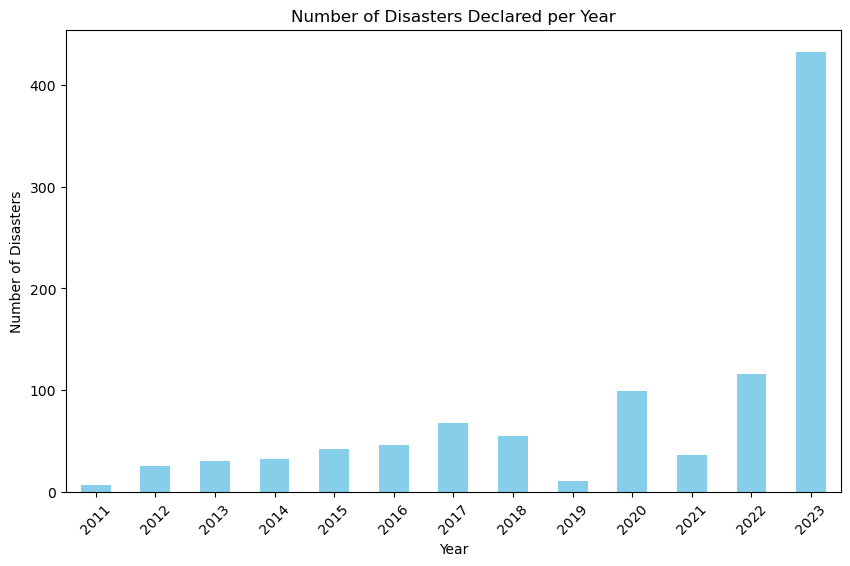

Top 10 States by Number of Disasters:
  State  Number of Disasters
0    CA                  179
1    KY                  111
2    WA                   78
3    TN                   73
4    FL                   71
5    OR                   49
6    SC                   42
7    MT                   37
8    TX                   36
9    NV                   24
Processed data saved to fema_disaster_declarations_processed.csv

Analysis complete.


In [45]:
# Fetch FEMA Disaster Data
def fetch_fema_disaster_data(start_date, end_date):
    base_url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries"
    filters = f"?$filter=declarationDate ge '{start_date}' and declarationDate le '{end_date}'"
    api_query = base_url + filters

    all_data = []
    while api_query:
        response = requests.get(api_query)
        if response.status_code != 200:
            break
        data = response.json()
        all_data.extend(data['DisasterDeclarationsSummaries'])
        api_query = data['metadata']['nextPageUrl'] if 'nextPageUrl' in data['metadata'] else None

    return pd.DataFrame(all_data)

# Process FEMA Data
def process_fema_data(df):
    # Convert date columns to datetime
    date_columns = ['declarationDate', 'incidentBeginDate', 'incidentEndDate']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

    # Fill missing values and drop irrelevant columns
    fill_values = {
        'fyDeclared': 0, 
        'declarationTitle': '', 
        'ihProgramDeclared': False, 
        'iaProgramDeclared': False, 
        'paProgramDeclared': False, 
        'hmProgramDeclared': False
    }
    if 'state' in df.columns:
        fill_values['state'] = ''

    df = df.fillna(fill_values)
    
    drop_columns = ['declarationTitle', 'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 'hmProgramDeclared']
    drop_columns = [col for col in drop_columns if col in df.columns]
    df = df.drop(columns=drop_columns)

    return df

# Analyze FEMA Data
def analyze_fema_data(df):
    # Plot the number of disasters declared each year
    df['year'] = df['declarationDate'].dt.year
    disasters_per_year = df.groupby('year').size()

    plt.figure(figsize=(10, 6))
    disasters_per_year.plot(kind='bar', color='skyblue')
    plt.title('Number of Disasters Declared per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.xticks(rotation=45)
    plt.show()

# Rank by State
def rank_by_state(df):
    state_ranking = None

    if 'state' in df.columns:
        state_ranking = df['state'].value_counts().reset_index()
        state_ranking.columns = ['State', 'Number of Disasters']

    return state_ranking

# Example Usage
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch data
raw_data = fetch_fema_disaster_data(start_date, end_date)
print(f"Fetched {len(raw_data)} records")
print("Columns in fetched data:", raw_data.columns)

# Process data
processed_data = process_fema_data(raw_data)
print("Processed data:")

# Analyze data
analyze_fema_data(processed_data)

# Rank by state
state_ranking = rank_by_state(processed_data)

if state_ranking is not None:
    print("Top 10 States by Number of Disasters:")
    print(state_ranking.head(10))
else:
    print("State data not available.")

# Save processed data to CSV
output_file = 'fema_disaster_declarations_processed.csv'
processed_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

print("\nAnalysis complete.")
